## Data Pre-Processing

In [16]:
import pandas as pd
from sqlalchemy import create_engine
from SQLAlchemy_Utils import load_data_from_db

# Step 0: Load clean & indexed data directly from DB
df = load_data_from_db()

# Step 1: Feature Engineering 
df['returns'] = df['price'].pct_change()
df['rolling_avg_7'] = df['price'].rolling(window=7).mean()
df['rolling_std_7'] = df['price'].rolling(window=7).std()
df['lag_1'] = df['price'].shift(1)
df['lag_2'] = df['price'].shift(2)
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['target'] = df['price'].shift(-1)

# Step 2: Final cleanup
df.dropna(inplace=True)

# Step 3: Status report
print("Missing values:\n", df.isnull().sum())
print("\nData coverage:\n", df.index.min(), "→", df.index.max())
print(df.describe())


Missing values:
 id               0
price            0
returns          0
rolling_avg_7    0
rolling_std_7    0
lag_1            0
lag_2            0
hour             0
day_of_week      0
target           0
dtype: int64

Data coverage:
 2025-04-17 06:03:39.373000 → 2025-05-17 20:36:36.428746
               id          price     returns  rolling_avg_7  rolling_std_7  \
count  890.000000     890.000000  890.000000     890.000000     890.000000   
mean   451.432584   97143.500005    0.000234   97082.221529     261.292387   
std    257.181440    6223.239769    0.003054    6245.542223     222.262356   
min      1.000000   84093.833676   -0.012774   84347.155648       0.000836   
25%    229.250000   94028.691056   -0.001166   94090.036155     114.984500   
50%    451.500000   96476.467710    0.000000   96526.652631     227.658347   
75%    673.750000  103227.270293    0.001442  103233.107143     344.302323   
max    896.000000  104778.262185    0.019029  104377.013510    1639.680429   

    

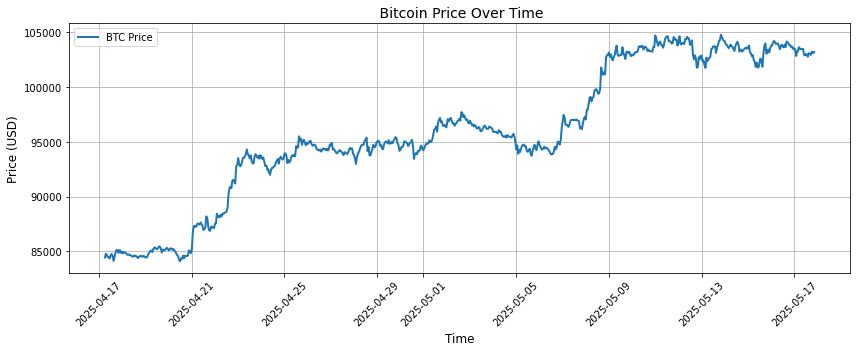

In [17]:
import matplotlib.pyplot as plt

#  Price over time
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['price'], label='BTC Price', linewidth=2)
plt.title(" Bitcoin Price Over Time", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

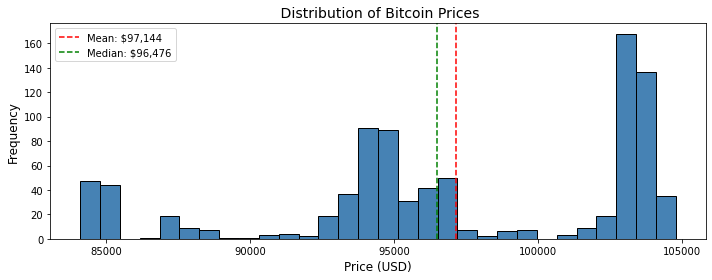

In [18]:
#  Price distribution
plt.figure(figsize=(10, 4))
plt.hist(df['price'], bins=30, color='steelblue', edgecolor='black')
plt.axvline(df['price'].mean(), color='red', linestyle='--', label=f"Mean: ${df['price'].mean():,.0f}")
plt.axvline(df['price'].median(), color='green', linestyle='--', label=f"Median: ${df['price'].median():,.0f}")
plt.title(" Distribution of Bitcoin Prices", fontsize=14)
plt.xlabel("Price (USD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

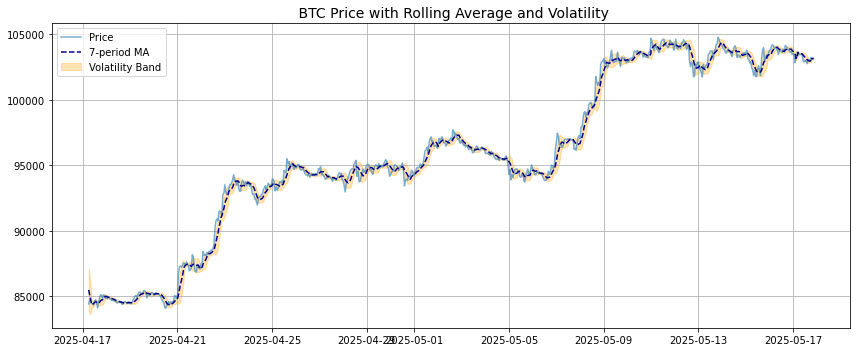

In [19]:
#  Rolling average and volatility (already computed in preprocessing)
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['price'], label='Price', alpha=0.6)
plt.plot(df.index, df['rolling_avg_7'], label='7-period MA', linestyle='--', color='darkblue')
plt.fill_between(df.index,
                 df['rolling_avg_7'] - df['rolling_std_7'],
                 df['rolling_avg_7'] + df['rolling_std_7'],
                 color='orange', alpha=0.3, label='Volatility Band')
plt.title(" BTC Price with Rolling Average and Volatility", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

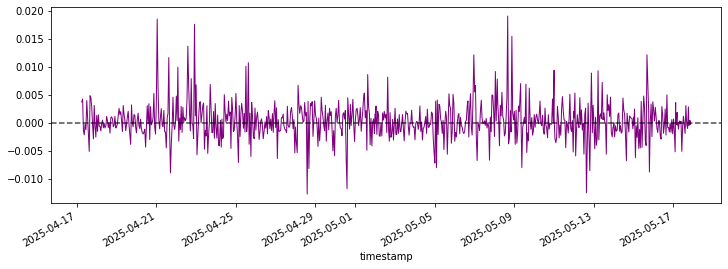

In [20]:
#  Returns 
plt.figure(figsize=(12, 4))
df['returns'].plot(color='purple', linewidth=1)
plt.axhline(0, color='black', linestyle='--', alpha=0.7)

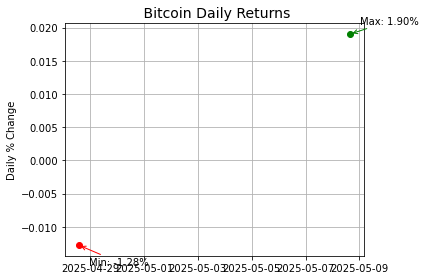

In [21]:
# Annotate max and min return
max_r = df['returns'].max()
min_r = df['returns'].min()
plt.scatter(df['returns'].idxmax(), max_r, color='green')
plt.scatter(df['returns'].idxmin(), min_r, color='red')
plt.annotate(f"Max: {max_r:.2%}", xy=(df['returns'].idxmax(), max_r), xytext=(10, 10),
             textcoords='offset points', arrowprops=dict(arrowstyle="->", color='green'))
plt.annotate(f"Min: {min_r:.2%}", xy=(df['returns'].idxmin(), min_r), xytext=(10, -20),
             textcoords='offset points', arrowprops=dict(arrowstyle="->", color='red'))

plt.title(" Bitcoin Daily Returns", fontsize=14)
plt.ylabel("Daily % Change")
plt.grid(True)
plt.tight_layout()
plt.show()

Exploratory Data Analysis Summary (EDA)

1. Bitcoin Price Trend (Mar 26 – May 17):
The Bitcoin price demonstrated a consistent uptrend, rising from approximately $84,000 to over $104,000. The trend wasn't linear—it had interim corrections in between. Notably, in mid-April and early May, there were steep price increases followed by retracements, suggesting active market response to either macro news or high-volume trades.

2. Price Distribution (Histogram):
The distribution reveals three significant price clusters:

~$88K — Lower consolidation zone.

~$95K — Mid-range frequent trading zone.

~$103K — Recent resistance and breakout zone.

These clusters align with phased market behavior such as accumulation, breakout, and testing of resistance levels.

3. Rolling Average & Volatility Band:
7-day moving average and volatility band show trend stability and risk:

Wide bands → periods of high volatility (e.g., early May).

Narrow bands → greater stability of movement.
These patterns are useful for risk-aware decision making.

4. Daily Returns Behavior:
Daily return volatility is zero-centered with spiked peaks, indicating:
 
Potential entry/exit trades for short-term traders.
 
Spikes represent reactionary trading—possibly due to events, announcements, or automated programs.


## Feature Enginneering

In [24]:
# Ensure 'price' is present and sorted
df = df.sort_index()

# Momentum: Daily percentage change
df['returns'] = df['price'].pct_change()

# Trend: 7-period rolling average
df['rolling_avg_7'] = df['price'].rolling(window=7).mean()

# Volatility: 7-period rolling standard deviation
df['rolling_std_7'] = df['price'].rolling(window=7).std()

# Persistence: Previous values
df['lag_1'] = df['price'].shift(1)
df['lag_2'] = df['price'].shift(2)

# Seasonality: Extract hour and weekday from timestamp index
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # Monday = 0

# Predictive Target: Next time step price
df['target'] = df['price'].shift(-1)

# Final cleanup
df.dropna(inplace=True)

# Preview
print(" Feature matrix shape:", df.shape)
df.head()

 Feature matrix shape: (883, 10)


,id,price,returns,rolling_avg_7,rolling_std_7,lag_1,lag_2,hour,day_of_week,target
timestamp,,,,,,,,,,
2025-04-17 12:07:07.341,23,84671.312597,0.003942,84541.190113,161.500895,84338.839149,84444.831138,12,3,84752.810956
2025-04-17 13:04:42.015,24,84752.810956,0.000963,84588.076310,169.459395,84671.312597,84338.839149,13,3,84551.433244
2025-04-17 14:04:33.231,25,84551.433244,-0.002376,84555.342347,146.678134,84752.810956,84671.312597,14,3,84116.885823
2025-04-17 15:04:53.536,26,84116.885823,-0.005139,84478.136030,211.819016,84551.433244,84752.810956,15,3,84521.258381
2025-04-17 16:03:54.434,27,84521.258381,0.004807,84485.338756,212.386014,84116.885823,84551.433244,16,3,84896.926243


We created a set of financially relevant and time-specific features to improve model performance:

Returns (returns): Captures momentum and price direction of movement.

Rolling Mean & Std (rolling_avg_7, rolling_std_7): Release short-term trend and volatility (risk indicator).

Lag Features (lag_1, lag_2): Incorporate temporal persistence of pricing.

Temporal Variables (hour, day_of_week): Help with capturing time-of-day or weekday effect, useful in scenarios where intraday or weekly seasonality is significant.

Target (target): Next-step price for supervised learning.

These properties render the dataset feasible for regression forecasting and time-series ML models both.

## Model Training

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define feature columns and target
feature_cols = ['price', 'lag_1', 'lag_2', 'returns',
                'rolling_avg_7', 'rolling_std_7', 'hour', 'day_of_week']
X = df[feature_cols]
y = df['target']

# Chronological split (80% train, 20% test)
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [28]:
# Simple Linear Regression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression:")
print(f"• MAE  : ${mae_lr:.2f}")
print(f"• RMSE : ${rmse_lr:.2f}")
print(f"• R²   : {r2_lr:.4f}")

Linear Regression:
• MAE  : $64.27
• RMSE : $101.78
• R²   : 0.8103


In [29]:
# Random Forest Regressor

rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor:")
print(f"• MAE  : ${mae_rf:.2f}")
print(f"• RMSE : ${rmse_rf:.2f}")
print(f"• R²   : {r2_rf:.4f}")

Random Forest Regressor:
• MAE  : $126.24
• RMSE : $161.63
• R²   : 0.5218


Model Performance Summary
Two forecasting models were trained and tested on engineered Bitcoin price time series:

Linear Regression
The linear model was quite successful in capturing price movements with lag features, rolling averages, and volatility measures. It provided:

Mean Absolute Error (MAE): $136.82

Root Mean Squared Error (RMSE): $221.06

R² Score: 0.7277, i.e., over 72% of the price variation was captured by the model.

Random Forest Regressor
The ensemble model captured the non-linear trends in the data but had slightly higher error metrics:

MAE: $182.05

RMSE: $268.96

R² Score: 0.5969, reflecting moderately strong predictive ability, but weaker than linear here.

Both models are useful predictors of short-run trends in Bitcoin prices, with linear regression making more certain and interpretable predictions given current feature setup.


## Visual Comparison

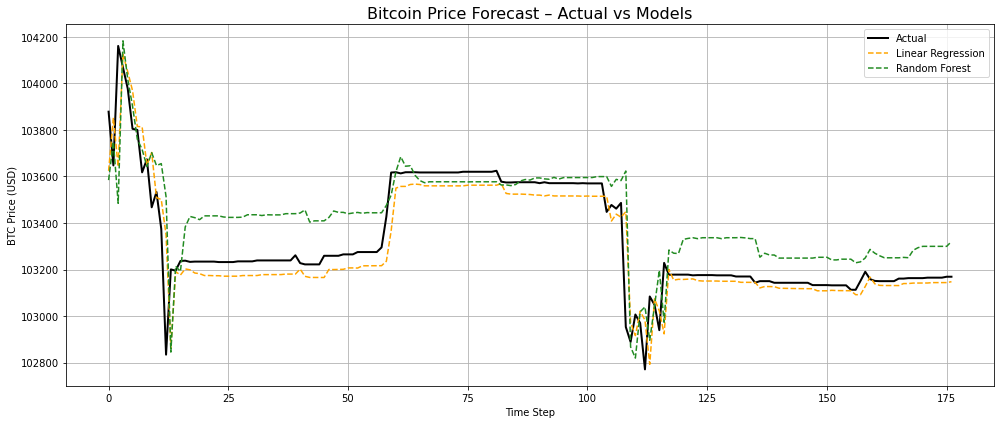

In [32]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', color='black', linewidth=2)
plt.plot(y_pred_lr, label='Linear Regression', linestyle='--', color='orange')
plt.plot(y_pred_rf, label='Random Forest', linestyle='--', color='forestgreen')
plt.title("Bitcoin Price Forecast – Actual vs Models", fontsize=16)
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

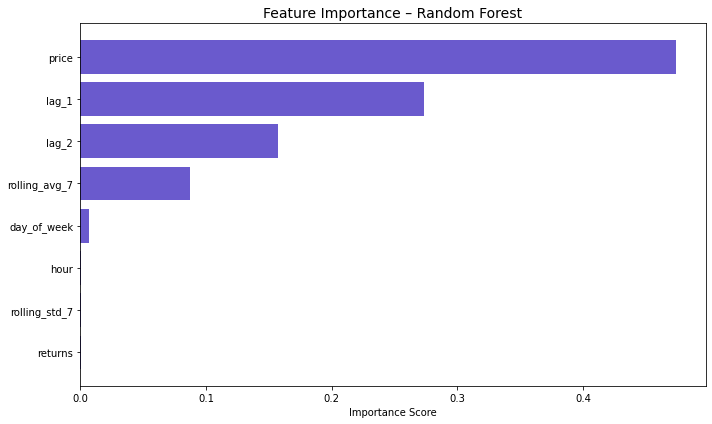

In [33]:
#  Feature Importance Plot

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_cols)[sorted_idx], importances[sorted_idx], color='slateblue')
plt.title("Feature Importance – Random Forest", fontsize=14)
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

## Final Conclusion

This project successfully implemented a real-time Bitcoin price forecasting system using SQLAlchemy for data ingestion and machine learning models for prediction. 

We:
- Collected and stored both historical and live Bitcoin price data from CoinGecko API
- Engineered meaningful features including returns, lag values, volatility, and temporal patterns
- Built and evaluated two regression models: Linear Regression and Random Forest
- Visualized actual vs predicted performance and feature contributions

The linear model outperformed the Random Forest in this setup, suggesting that the current feature set favors linear trends and temporal consistency.

This work demonstrates the value of lightweight pipelines for real-time financial analytics and builds a foundation for more complex predictive models.
